# Part 4: Convexity and Constrained Optimization

In [26]:
import importlib


import numpy as np # linear algebra
import pandas as pd #dataframe library
import sklearn # machine learning library
assert sklearn.__version__ >= '0.2'
from sklearn import datasets
import random
np.random.seed(seed=42) # to have same results each time
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import useful_functions
importlib.reload(useful_functions)
from useful_functions import generate_dataset, unison_shuffled_copies, get_train_test_datasets, gradient_descent, plot_convergence_rate, plot_evolution_on_test_error, plot_evolution_on_test_error_with_bias, plot_iterates_l2_2D, plot_iterates_l1_2D


## Question 1: implement the conditional gradient algorithm and the projected gradient algorithm on l-2 ball

### Generate dataset

In [4]:
nsamples = 200
sigma = 0.4
range_uniform=5
xtrain, ytrain = generate_dataset(nsamples,range_uniform, sigma)
xtest, ytest = generate_dataset(nsamples,range_uniform, sigma)

### Projected Gradient

In [5]:
#GD implementation to project on the l2-ball
n_epochs = 200
step_size = 1e-5
R = 3 #parameter for size of the ball
norm = 2

D  = xtrain.shape[1]
x = np.random.rand(D) # random initialization
x_proj = (R/max(np.linalg.norm(x,ord=2),R))*x

loss_function_array_gd = []
loss_function_array_gd_proj = []
X = np.zeros((D,n_epochs))
X_proj = np.zeros((D,n_epochs))
epochs = []

for epoch in range(n_epochs):
    #here only one iteration per epoch
    epochs.append(epoch)
    
    loss_function_train = np.linalg.norm(np.dot(xtrain,x)-ytrain)**2
    loss_function_train_proj = np.linalg.norm(np.dot(xtrain,x_proj)-ytrain)**2
    loss_function_array_gd.append(loss_function_train)
    loss_function_array_gd_proj.append(loss_function_train_proj)

    gradients = 2*xtrain.T.dot(np.dot(xtrain,x)-ytrain)
    x = x - step_size * gradients
    X[:,epoch] = x

    gradients_proj = 2*xtrain.T.dot(np.dot(xtrain,x_proj)-ytrain)
    x_proj = x_proj - step_size * gradients_proj
    x_proj = (R/max(np.linalg.norm(x,ord=norm),R))*x #projection on l2 ball
    X_proj[:,epoch] = x_proj

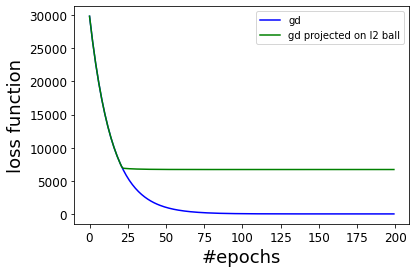

In [6]:
plt.plot(epochs, loss_function_array_gd, color = 'b', label = 'gd')
plt.plot(epochs, loss_function_array_gd_proj, color = 'g', label = 'gd projected on l2 ball')
plt.xlabel("#epochs", rotation=0, fontsize=18)
plt.ylabel("loss function", rotation=90, fontsize=18)
plt.legend()
plt.show()

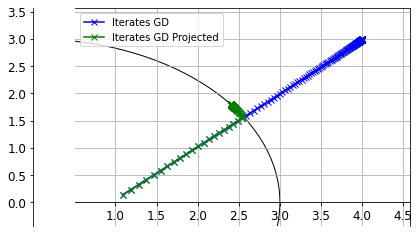

In [7]:
plot_iterates_l2_2D(X, X_proj, R, with_set=True)

### Conditional Gradient

In [8]:
def extreme_point_argmin(D, gradient, norm, R):
    '''
    Calculate the argmin from subproblem in Frank-Wolfe algorihtm
    '''
    q_ = 1/(1-1/norm)  #for ensuring Holder inequality
    s = np.zeros(D)
    a = 0
    for d in range(D):
         a = a + np.abs(gradient[d])**q_
    a = a**(1/norm)
    for d in range(D):
        s[d] = -R*np.sign(gradient[d])*np.abs(gradient[d])**(q_-1)/a

    return s 

In [40]:
#Conditional gradient implementation on l2-ball
n_epochs = 200
step_size = 1e-5
R = 5 #parameter for size of the ball
norm = 2

D  = xtrain.shape[1]
x = np.random.rand(D) # random initialization
x_proj = (R/max(np.linalg.norm(x,ord=2),R))*x

loss_function_array_gd = []
loss_function_array_gd_proj = []
X = np.zeros((D,n_epochs))
X_proj = np.zeros((D,n_epochs))
epochs = []

for epoch in range(n_epochs):
    #here only one iteration per epoch
    epochs.append(epoch)
    
    loss_function_train = np.linalg.norm(np.dot(xtrain,x)-ytrain)**2
    loss_function_train_proj = np.linalg.norm(np.dot(xtrain,x_proj)-ytrain)**2
    loss_function_array_gd.append(loss_function_train)
    loss_function_array_gd_proj.append(loss_function_train_proj)
    gradients = 2*xtrain.T.dot(np.dot(xtrain,x)-ytrain)
    x = x - step_size * gradients
    X[:,epoch] = x

    step_size_fw = 2/(2+epoch)
    gradients_proj = 2*xtrain.T.dot(np.dot(xtrain,x_proj)-ytrain)
    s = extreme_point_argmin(D, gradients_proj, norm, R)
    x_proj = step_size_fw*s + (1-step_size_fw)*x_proj
    X_proj[:,epoch] = x_proj

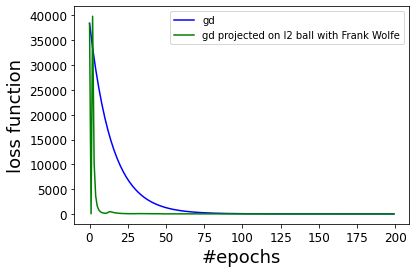

In [41]:
plt.plot(epochs, loss_function_array_gd, color = 'b', label = 'gd')
plt.plot(epochs, loss_function_array_gd_proj, color = 'g', label = 'gd projected on l2 ball with Frank Wolfe')
plt.xlabel("#epochs", rotation=0, fontsize=18)
plt.ylabel("loss function", rotation=90, fontsize=18)
plt.legend()
plt.show()

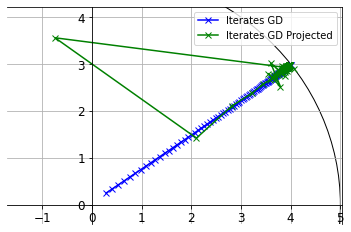

In [42]:
plot_iterates_l2_2D(X, X_proj, R, with_set=True)

## Question 2: implement the conditional gradient algorithm and the projected gradient algorithm on l-1 ball

### Projected Gradient

In [12]:
#GD implementation to project on the l2-ball
n_epochs = 200
step_size = 1e-5
R = 3 #parameter for size of the ball
norm = 1

D  = xtrain.shape[1]
x = np.random.rand(D) # random initialization
x_proj = (R/max(np.linalg.norm(x,ord=1),R))*x

loss_function_array_gd = []
loss_function_array_gd_proj = []
X = np.zeros((D,n_epochs))
X_proj = np.zeros((D,n_epochs))
epochs = []

for epoch in range(n_epochs):
    #here only one iteration per epoch
    epochs.append(epoch)
    
    loss_function_train = np.linalg.norm(np.dot(xtrain,x)-ytrain)**2
    loss_function_train_proj = np.linalg.norm(np.dot(xtrain,x_proj)-ytrain)**2
    loss_function_array_gd.append(loss_function_train)
    loss_function_array_gd_proj.append(loss_function_train_proj)

    gradients = 2*xtrain.T.dot(np.dot(xtrain,x)-ytrain)
    x = x - step_size * gradients
    X[:,epoch] = x

    gradients_proj = 2*xtrain.T.dot(np.dot(xtrain,x_proj)-ytrain)
    x_proj = x_proj - step_size * gradients_proj
    x_proj = (R/max(np.linalg.norm(x,ord=norm),R))*x #projection on l1 ball
    X_proj[:,epoch] = x_proj

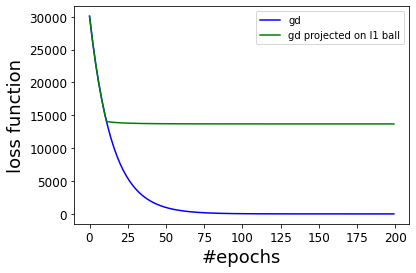

In [14]:
plt.plot(epochs, loss_function_array_gd, color = 'b', label = 'gd')
plt.plot(epochs, loss_function_array_gd_proj, color = 'g', label = 'gd projected on l1 ball')
plt.xlabel("#epochs", rotation=0, fontsize=18)
plt.ylabel("loss function", rotation=90, fontsize=18)
plt.legend()
plt.show()

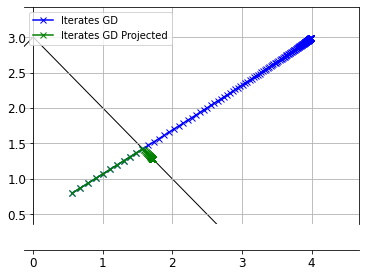

In [27]:
plot_iterates_l1_2D(X, X_proj, R, with_set=True)

### Conditional Gradient 

In [78]:
def extreme_point_argmin(D, gradient, norm, R):
    '''
    Calculate the argmin from subproblem in Frank-Wolfe algorihtm
    '''

    if norm >=2:
        q_ = 1/(1-1/norm)  #for ensuring Holder inequality
        s = np.zeros(D)
        a = 0
        for d in range(D):
            a = a + np.abs(gradient[d])**q_
        a = a**(1/norm)
        for d in range(D):
            s[d] = -R*np.sign(gradient[d])*np.abs(gradient[d])**(q_-1)/a

        return s 
        
    elif norm == 1:
        s = np.zeros(D)
        k0 = np.argmax(np.abs(gradient))
        s[k0]=R
        s = -np.sign(gradient[k0])*s
        return s

In [79]:
#Conditional gradient implementation on l2-ball
n_epochs = 200
step_size = 1e-5
R = 5 #parameter for size of the ball
norm = 1

D  = xtrain.shape[1]
x = np.random.rand(D) # random initialization
x_proj = (R/max(np.linalg.norm(x,ord=1),R))*x

loss_function_array_gd = []
loss_function_array_gd_proj = []
X = np.zeros((D,n_epochs))
X_proj = np.zeros((D,n_epochs))
epochs = []

for epoch in range(n_epochs):
    #here only one iteration per epoch
    epochs.append(epoch)
    
    loss_function_train = np.linalg.norm(np.dot(xtrain,x)-ytrain)**2
    loss_function_train_proj = np.linalg.norm(np.dot(xtrain,x_proj)-ytrain)**2
    loss_function_array_gd.append(loss_function_train)
    loss_function_array_gd_proj.append(loss_function_train_proj)
    gradients = 2*xtrain.T.dot(np.dot(xtrain,x)-ytrain)
    x = x - step_size * gradients
    X[:,epoch] = x

    step_size_fw = 2/(2+epoch)
    gradients_proj = 2*xtrain.T.dot(np.dot(xtrain,x_proj)-ytrain)
    s = extreme_point_argmin(D, gradients_proj, norm, R)
    x_proj = step_size_fw*s + (1-step_size_fw)*x_proj
    X_proj[:,epoch] = x_proj

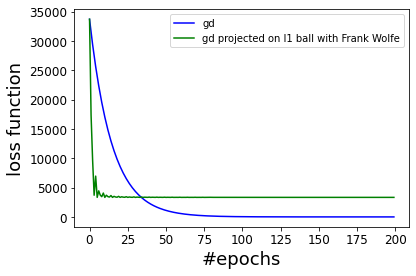

In [82]:
plt.plot(epochs, loss_function_array_gd, color = 'b', label = 'gd')
plt.plot(epochs, loss_function_array_gd_proj, color = 'g', label = 'gd projected on l1 ball with Frank Wolfe')
plt.xlabel("#epochs", rotation=0, fontsize=18)
plt.ylabel("loss function", rotation=90, fontsize=18)
plt.legend()
plt.show()

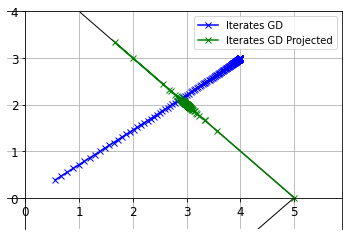

In [83]:
plot_iterates_l1_2D(X, X_proj, R, with_set=True)